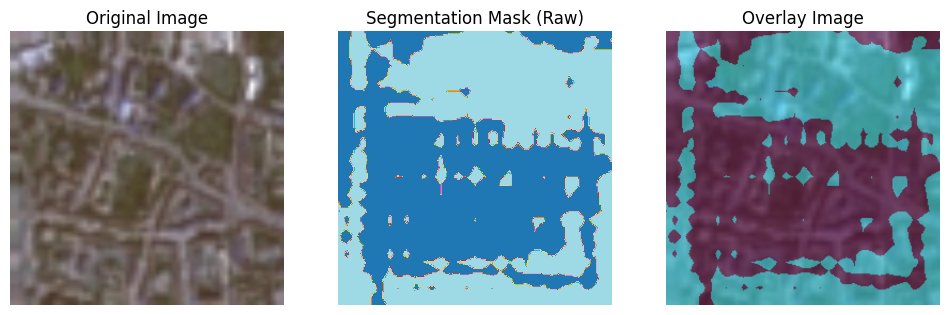

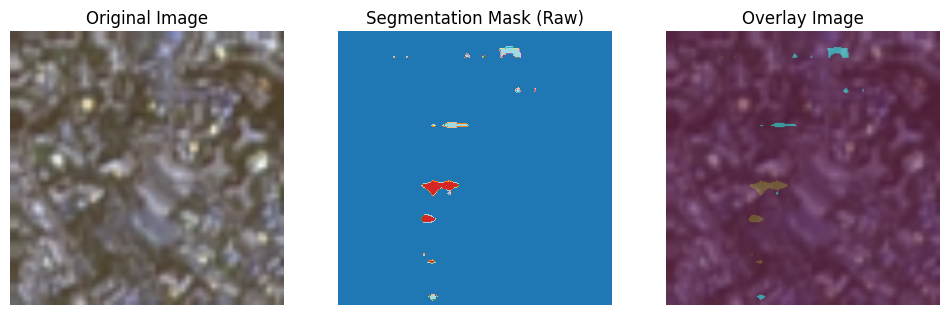

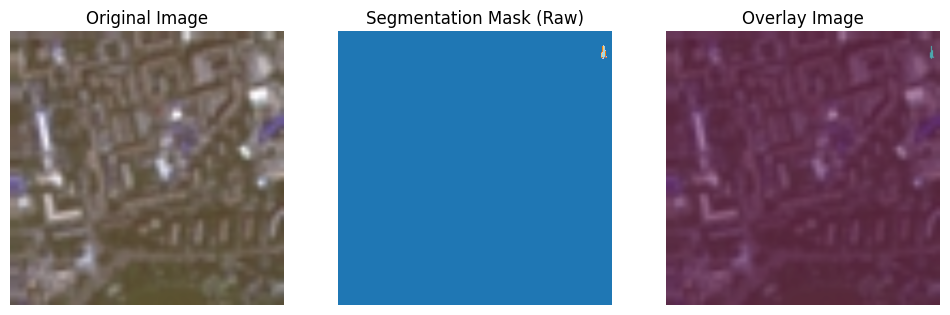

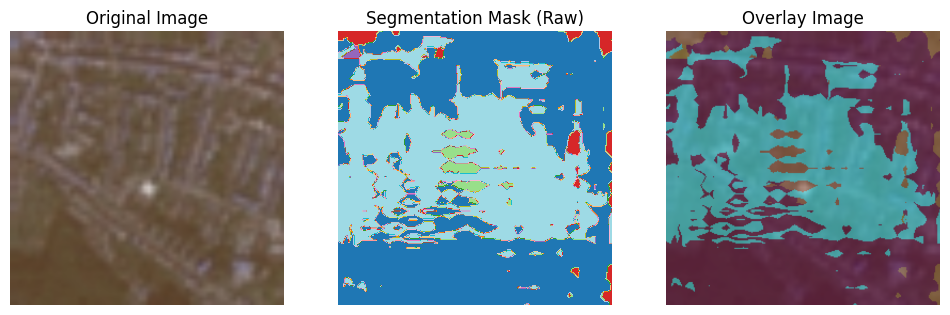

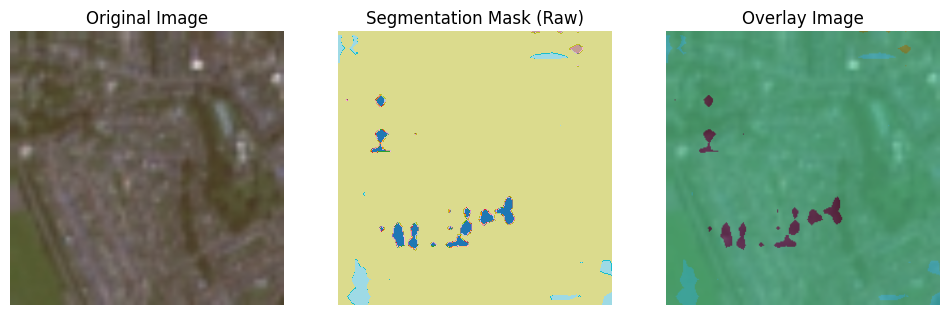

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2  # Ensure OpenCV is installed: pip install opencv-python

# Configuration
category = "Residential"
split = "test"
training_data_dir = f"../data/training_data/{split}"
output_masks_dir = f"../data/single_channel_masks/{category}/{split}"
batch_size = 20  # Adjust this based on your processing script
alpha = 0.5  # Transparency for overlay
color_map = cv2.COLORMAP_VIRIDIS  # Smoother color map

# Load images
image_path = os.path.join(training_data_dir, f"{category}_{split}.npy")
images = np.load(image_path)

# List all batched mask files
batch_files = sorted([os.path.join(output_masks_dir, f) for f in os.listdir(output_masks_dir) if f.startswith("batch_")])

for i in range(5):  # Visualize the first 5 images
    # Original image
    original_image = images[i]

    # Normalize the original image to uint8 for visualization
    if original_image.max() <= 1.0:
        original_image = (original_image * 255).astype(np.uint8)
    elif original_image.dtype != np.uint8:
        original_image = original_image.astype(np.uint8)

    # Determine which batch file contains the mask for this image
    batch_index = i // batch_size
    mask_index = i % batch_size

    if batch_index >= len(batch_files):
        print(f"No mask batch available for image {i}. Skipping.")
        continue

    # Load the corresponding batch
    mask_batch_path = batch_files[batch_index]
    mask_batch = np.load(mask_batch_path)

    # Extract the specific mask
    segmentation_mask_resized = mask_batch[mask_index]

    # Normalize the mask for visualization
    segmentation_mask_normalized = (segmentation_mask_resized / segmentation_mask_resized.max()) * 255
    segmentation_mask_normalized = segmentation_mask_normalized.astype(np.uint8)

    # Apply color map
    color_mapped_mask = cv2.applyColorMap(segmentation_mask_normalized, color_map)

    # Create overlay
    overlay_image = cv2.addWeighted(original_image, alpha, color_mapped_mask, 1 - alpha, 0)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(segmentation_mask_resized, cmap="tab20")
    plt.title("Segmentation Mask (Raw)")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay_image)
    plt.title("Overlay Image")
    plt.axis("off")
    plt.show()


In [5]:
# 1. Entropy (Measure of Class Diversity)

import os
import numpy as np
from scipy.stats import entropy

# Paths
output_masks_dir = "../data/single_channel_masks"

# Function to calculate entropy for a single mask
def calculate_entropy(segmentation_mask_class):
    unique, counts = np.unique(segmentation_mask_class, return_counts=True)
    class_probabilities = counts / np.sum(counts)
    return entropy(class_probabilities)

# Function to process all categories and splits
def calculate_entropy_for_all_masks(output_masks_dir):
    results = {}

    for category in os.listdir(output_masks_dir):  # Iterate over categories
        category_path = os.path.join(output_masks_dir, category)
        if not os.path.isdir(category_path):
            continue
        
        category_results = {}
        for split in ["train", "val", "test"]:  # Iterate over splits
            split_path = os.path.join(category_path, split)
            if not os.path.exists(split_path):
                continue

            entropies = []
            for mask_file in os.listdir(split_path):  # Iterate over masks
                mask_path = os.path.join(split_path, mask_file)
                segmentation_mask = np.load(mask_path)
                segmentation_mask_class = np.argmax(segmentation_mask, axis=-1)
                mask_entropy = calculate_entropy(segmentation_mask_class)
                entropies.append(mask_entropy)

            if entropies:
                category_results[split] = {
                    "average_entropy": np.mean(entropies),
                    "num_masks": len(entropies),
                }

        results[category] = category_results

    return results

# Main execution
results = calculate_entropy_for_all_masks(output_masks_dir)

# Print results
for category, splits in results.items():
    print(f"Category: {category}")
    for split, stats in splits.items():
        print(f"  Split: {split}")
        print(f"    Average Entropy: {stats['average_entropy']:.4f}")
        print(f"    Number of Masks: {stats['num_masks']}")


Category: Highway
  Split: train
    Average Entropy: 2.4522
    Number of Masks: 80
  Split: val
    Average Entropy: 2.3631
    Number of Masks: 20
  Split: test
    Average Entropy: 2.3210
    Number of Masks: 25
Category: HerbaceousVegetation
  Split: train
    Average Entropy: 2.0847
    Number of Masks: 96
  Split: val
    Average Entropy: 2.0925
    Number of Masks: 24
  Split: test
    Average Entropy: 2.0277
    Number of Masks: 30
Category: Residential
  Split: train
    Average Entropy: 2.6009
    Number of Masks: 96
  Split: val
    Average Entropy: 2.7089
    Number of Masks: 24
  Split: test
    Average Entropy: 2.6990
    Number of Masks: 30
Category: Forest
  Split: train
    Average Entropy: 1.2844
    Number of Masks: 96
  Split: val
    Average Entropy: 1.3025
    Number of Masks: 24
  Split: test
    Average Entropy: 1.2633
    Number of Masks: 30
Category: Industrial
  Split: train
    Average Entropy: 3.0256
    Number of Masks: 80
  Split: val
    Average Entropy

In [6]:
# Pixel Distribution Across All Categories and Splits
# Displays the percentage of pixels for each class in a structured format.

import os
import numpy as np

# Paths
output_masks_dir = "../data/single_channel_masks"

# Function to calculate pixel distribution for a single mask directory
def calculate_pixel_distribution(mask_dir):
    category_results = {}
    for mask_file in os.listdir(mask_dir):
        mask_path = os.path.join(mask_dir, mask_file)
        segmentation_mask = np.load(mask_path)
        segmentation_mask_class = np.argmax(segmentation_mask, axis=-1)

        # Count pixels for each class
        unique, counts = np.unique(segmentation_mask_class, return_counts=True)
        class_distribution = dict(zip(unique, counts))

        # Aggregate results
        for cls, count in class_distribution.items():
            if cls not in category_results:
                category_results[cls] = 0
            category_results[cls] += count

    # Normalize results to percentage
    total_pixels = sum(category_results.values())
    class_percentages = {cls: (count / total_pixels) * 100 for cls, count in category_results.items()}

    return class_percentages

# Function to process all categories and splits
def analyze_pixel_distribution(output_masks_dir):
    results = {}

    for category in os.listdir(output_masks_dir):  # Iterate over categories
        category_path = os.path.join(output_masks_dir, category)
        if not os.path.isdir(category_path):
            continue

        category_results = {}
        for split in ["train", "val", "test"]:  # Iterate over splits
            split_path = os.path.join(category_path, split)
            if not os.path.exists(split_path):
                continue

            # Calculate pixel distribution for this split
            pixel_distribution = calculate_pixel_distribution(split_path)
            category_results[split] = pixel_distribution

        results[category] = category_results

    return results

# Main execution
pixel_distribution_results = analyze_pixel_distribution(output_masks_dir)

# Print results
for category, splits in pixel_distribution_results.items():
    print(f"Category: {category}")
    for split, distribution in splits.items():
        print(f"  Split: {split}")
        for cls, pct in distribution.items():
            print(f"    Class {cls}: {pct:.2f}%")


Category: Highway
  Split: train
    Class 0: 63.63%
    Class 2: 0.67%
    Class 4: 0.71%
    Class 6: 0.74%
    Class 8: 0.76%
    Class 10: 0.81%
    Class 12: 0.79%
    Class 14: 0.81%
    Class 16: 0.90%
    Class 18: 0.14%
    Class 20: 0.19%
    Class 22: 0.22%
    Class 24: 0.26%
    Class 26: 0.29%
    Class 28: 0.37%
    Class 30: 0.42%
    Class 32: 0.43%
    Class 34: 0.12%
    Class 36: 0.17%
    Class 38: 0.18%
    Class 40: 0.19%
    Class 42: 0.27%
    Class 44: 0.29%
    Class 46: 0.28%
    Class 48: 0.34%
    Class 50: 0.09%
    Class 52: 0.12%
    Class 54: 0.13%
    Class 56: 0.18%
    Class 58: 0.22%
    Class 60: 0.29%
    Class 62: 0.37%
    Class 64: 0.39%
    Class 66: 0.08%
    Class 68: 0.10%
    Class 70: 0.12%
    Class 72: 0.13%
    Class 74: 0.19%
    Class 76: 0.21%
    Class 78: 0.28%
    Class 80: 0.36%
    Class 82: 0.06%
    Class 84: 0.09%
    Class 86: 0.09%
    Class 88: 0.12%
    Class 90: 0.16%
    Class 92: 0.21%
    Class 94: 0.24%
    Class 9

In [9]:
import os
import numpy as np
from skimage.measure import label, regionprops

# Function to calculate compactness for a single segmentation mask
def calculate_compactness(segmentation_mask):
    compactness_results = {}

    # Iterate over unique classes in the mask
    unique_classes = np.unique(segmentation_mask)
    for cls in unique_classes:
        if cls == 0:  # Ignore background class (if applicable)
            continue

        # Binary mask for the current class
        binary_mask = (segmentation_mask == cls).astype(np.uint8)

        # Label connected components
        labeled_mask = label(binary_mask, connectivity=2)
        regions = regionprops(labeled_mask)

        # Calculate compactness for each connected region
        compactness_scores = [
            (4 * np.pi * region.area) / (region.perimeter ** 2 + 1e-5)
            for region in regions if region.perimeter > 0
        ]

        # Average compactness for this class
        if compactness_scores:
            compactness_results[cls] = np.mean(compactness_scores)
        else:
            compactness_results[cls] = 0  # No valid regions

    return compactness_results

# Function to process all categories and splits
def analyze_compactness(output_masks_dir):
    compactness_results = {}

    for category in os.listdir(output_masks_dir):  # Iterate over categories
        category_path = os.path.join(output_masks_dir, category)
        if not os.path.isdir(category_path):
            continue

        category_compactness = {}
        for split in ["train", "val", "test"]:  # Iterate over splits
            split_path = os.path.join(category_path, split)
            if not os.path.exists(split_path):
                continue

            # Aggregate compactness scores for this split
            split_compactness = []
            for mask_file in os.listdir(split_path):
                mask_path = os.path.join(split_path, mask_file)
                segmentation_mask = np.load(mask_path)
                segmentation_mask_class = np.argmax(segmentation_mask, axis=-1)

                compactness = calculate_compactness(segmentation_mask_class)
                split_compactness.append(compactness)

            # Average compactness for each class
            class_compactness_avg = {}
            for compactness in split_compactness:
                for cls, score in compactness.items():
                    if cls not in class_compactness_avg:
                        class_compactness_avg[cls] = []
                    class_compactness_avg[cls].append(score)
            for cls, scores in class_compactness_avg.items():
                class_compactness_avg[cls] = np.mean(scores)

            category_compactness[split] = class_compactness_avg

        compactness_results[category] = category_compactness

    return compactness_results

# Paths
output_masks_dir = "../data/single_channel_masks"

# Main execution
compactness_results = analyze_compactness(output_masks_dir)

# Condensed Results
overall_compactness = {}

for category, splits in compactness_results.items():
    class_avg_compactness = {}

    for split, compactness in splits.items():
        for cls, score in compactness.items():
            if cls not in class_avg_compactness:
                class_avg_compactness[cls] = []
            class_avg_compactness[cls].append(score)

    # Average compactness across all splits for each class
    for cls, scores in class_avg_compactness.items():
        class_avg_compactness[cls] = np.mean(scores)

    overall_compactness[category] = class_avg_compactness

# Print condensed results
for category, class_compactness in overall_compactness.items():
    print(f"Category: {category}")
    for cls, avg_score in class_compactness.items():
        print(f"  Class {cls}: Avg Compactness: {avg_score:.4f}")


Category: Highway
  Class 2: Avg Compactness: 7.8517
  Class 4: Avg Compactness: 7.5669
  Class 6: Avg Compactness: 7.8240
  Class 8: Avg Compactness: 8.2429
  Class 10: Avg Compactness: 7.8286
  Class 12: Avg Compactness: 7.2981
  Class 14: Avg Compactness: 7.7034
  Class 16: Avg Compactness: 7.6416
  Class 18: Avg Compactness: 5.9410
  Class 20: Avg Compactness: 6.3737
  Class 22: Avg Compactness: 7.0047
  Class 24: Avg Compactness: 7.1603
  Class 26: Avg Compactness: 7.1526
  Class 28: Avg Compactness: 7.3328
  Class 30: Avg Compactness: 7.6228
  Class 32: Avg Compactness: 7.0920
  Class 34: Avg Compactness: 5.1351
  Class 36: Avg Compactness: 5.5091
  Class 38: Avg Compactness: 7.9233
  Class 40: Avg Compactness: 6.9576
  Class 42: Avg Compactness: 7.5667
  Class 44: Avg Compactness: 7.1771
  Class 46: Avg Compactness: 7.6384
  Class 48: Avg Compactness: 7.8266
  Class 50: Avg Compactness: 5.6626
  Class 52: Avg Compactness: 5.2763
  Class 54: Avg Compactness: 6.2727
  Class 56: Av